In [1]:
#This loads all the data
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import random

# Load CIFAR-10
cifar_transform = transforms.Compose([
    transforms.ToTensor()
])

cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=cifar_transform, download=True)

Files already downloaded and verified


In [17]:
#This section downloads MNIST and adds some gaussian noise to it
# Function to add Gaussian noise
def add_gaussian_noise(tensor, mean=0.0, std=0.2):
    noise = torch.randn(tensor.size()) * std + mean
    noisy_tensor = tensor + noise
    return torch.clamp(noisy_tensor, 0, 1)  # Keep values in [0,1]

# Transform pipeline with Gaussian noise
mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match CIFAR
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_gaussian_noise(x))  # Apply Gaussian noise
])

# Load MNIST dataset with the modified transform
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)

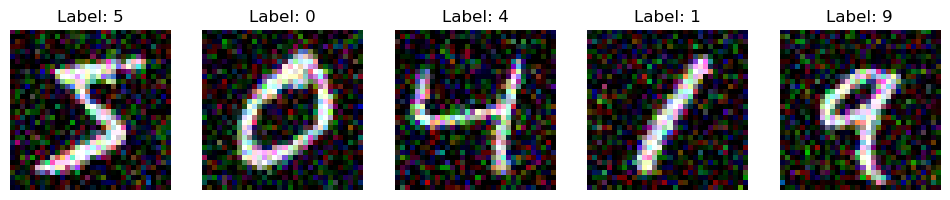

In [22]:
import matplotlib.pyplot as plt

# Get a few images from the dataset
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

for i in range(num_images):
    image, label = mnist_data[i]  # Get image and label
    image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C) and NumPy format
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

In [19]:
# Map MNIST digits to CIFAR-10 classes
mnist_to_cifar_map = {
    0: 'airplane',
    1: 'automobile',  # Pair "1" in MNIST with "car" in CIFAR-10
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# Get CIFAR class indices (precompute for speed)
cifar_class_to_idx = {class_name: idx for idx, class_name in enumerate(cifar_data.classes)}
cifar_class_indices = {class_name: [] for class_name in cifar_data.classes}

# Store indices of CIFAR images per class
for i, (_, label) in enumerate(cifar_data):
    class_name = cifar_data.classes[label]
    cifar_class_indices[class_name].append(i)

# Create paired dataset
combined_images = []
combined_labels = []

for mnist_img, mnist_label in mnist_data:
    cifar_class_name = mnist_to_cifar_map[mnist_label]
    cifar_indices = cifar_class_indices[cifar_class_name]  # Get precomputed indices
    
    if not cifar_indices:
        continue  # Skip if no images (shouldn't happen)

    # Select a random image from the matching CIFAR class
    cifar_idx = random.choice(cifar_indices)
    cifar_img, _ = cifar_data[cifar_idx]

    # Concatenate images horizontally
    mnist_img = transforms.ToPILImage()(mnist_img)
    cifar_img = transforms.ToPILImage()(cifar_img)
    combined_img = Image.new('RGB', (64, 32))  # Create a new canvas
    combined_img.paste(mnist_img, (0, 0))
    combined_img.paste(cifar_img, (32, 0))

    # Convert back to tensor
    combined_tensor = transforms.ToTensor()(combined_img)
    
    # Store paired image and label
    combined_images.append(combined_tensor)
    combined_labels.append(mnist_label)  # Keeping MNIST labels

# Convert to dataset
class MNISTCIFARDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

combined_dataset = MNISTCIFARDataset(combined_images, combined_labels)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

print(f"Dataset successfully created with {len(combined_dataset)} images!")

Dataset successfully created with 60000 images!


In [20]:
print(len(combined_dataset))  # Make sure it contains data

60000


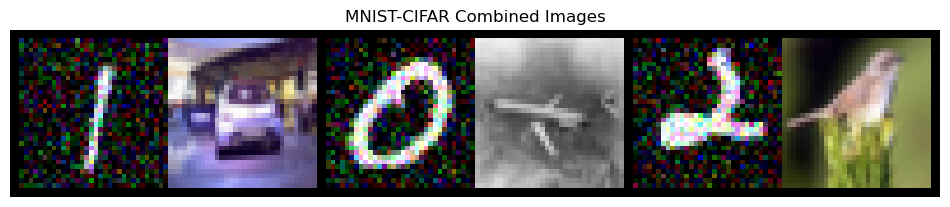

In [23]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to show a batch of combined MNIST-CIFAR images
def show_combined_images(dataloader, num_images=3):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)  # Get first batch

    # Select only the first `num_images` images
    images = images[:num_images]

    # Create a grid of images
    grid_img = vutils.make_grid(images, nrow=num_images, padding=2, normalize=True)

    # Display the images
    plt.figure(figsize=(12, 4))
    plt.imshow(grid_img.permute(1, 2, 0))  # Change from (C, H, W) to (H, W, C) for display
    plt.axis("off")
    plt.title("MNIST-CIFAR Combined Images")
    plt.show()

# Call function to display images
show_combined_images(combined_loader)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # First convolution layer: (3, 64, 32) -> (6, 60, 28)
        self.conv1 = nn.Conv2d(3, 6, 5)  
        
        # Maxpooling layer: (6, 60, 28) -> (6, 30, 14)
        self.pool = nn.MaxPool2d(2, 2) 
        
        # Second convolution layer: (6, 30, 14) -> (16, 26, 10)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Maxpooling layer: (16, 26, 10) -> (16, 13, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layer: (16 * 13 * 5) -> 120
        self.fc1 = nn.Linear(16 * 13 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply first convolution and pooling
        x = self.pool(F.relu(self.conv1(x)))  
        
        # Apply second convolution and pooling
        x = self.pool2(F.relu(self.conv2(x))) 
        
        # Flatten the output to pass it to the fully connected layers
        x = x.view(-1, 16 * 13 * 5)  # New size: 16 * 13 * 5 after two poolings
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Instantiate the model
net = Net()

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [34]:
import os

# Define paths
model_directory_path = 'model/'
model_path = os.path.join(model_directory_path, 'cifar-mnist-cnn-model.pt')

# Ensure directory exists
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

def load_model(net):
    """Loads the trained model if it exists."""
    if os.path.isfile(model_path):
        net.load_state_dict(torch.load(model_path))
        print('Loaded model parameters from disk.')
        return True  # Indicate successful loading
    else:
        print('No saved model found.')
        return False

def train_model(net, trainloader, criterion, optimizer, epochs=2):
    """Trains the model from scratch."""
    print("Starting training...")
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')

In [36]:
train_model(net, combined_loader, criterion, optimizer, 1)

Starting training...
[1,   200] loss: 0.019
[1,   400] loss: 0.017
[1,   600] loss: 0.016
[1,   800] loss: 0.014
[1,  1000] loss: 0.013
[1,  1200] loss: 0.012
[1,  1400] loss: 0.012
[1,  1600] loss: 0.011
[1,  1800] loss: 0.013
Finished Training.


In [8]:
def calculate_class_accuracies(model, testloader, classes):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize variables to track correct predictions for each class
    class_correct = [0] * len(classes)
    class_total = [0] * len(classes)

    # Iterate through the test dataset
    with torch.no_grad():  # Don't compute gradients during evaluation
        for data in testloader:
            images, labels = data  # Get images and corresponding labels
            outputs = model(images)  # Get model outputs
            _, predicted = torch.max(outputs, 1)  # Get predicted labels

            # Update correct predictions for each class
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1

    # Print accuracy for each class
    for i in range(len(classes)):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f'Accuracy for {classes[i]}: {accuracy:.2f}%')

# Example usage: Assuming testloader and class names are defined
# The 'classes' should be a list of class names for your dataset (e.g., CIFAR-10 classes)

# Define class names (CIFAR-10 example)
cifar_mnist_classes = ['airplane 0', 'automobile 1', 'bird 2', 'cat 3', 'deer 4', 'dog 5', 
                 'frog 6', 'horse 7', 'ship 8', 'truck 9']

# Call the function to calculate and print class-wise accuracies
calculate_class_accuracies(net, combined_loader, cifar_mnist_classes)

Accuracy for airplane 0: 99.34%
Accuracy for automobile 1: 98.40%
Accuracy for bird 2: 96.21%
Accuracy for cat 3: 96.87%
Accuracy for deer 4: 96.53%
Accuracy for dog 5: 96.31%
Accuracy for frog 6: 95.62%
Accuracy for horse 7: 97.70%
Accuracy for ship 8: 91.52%
Accuracy for truck 9: 97.41%


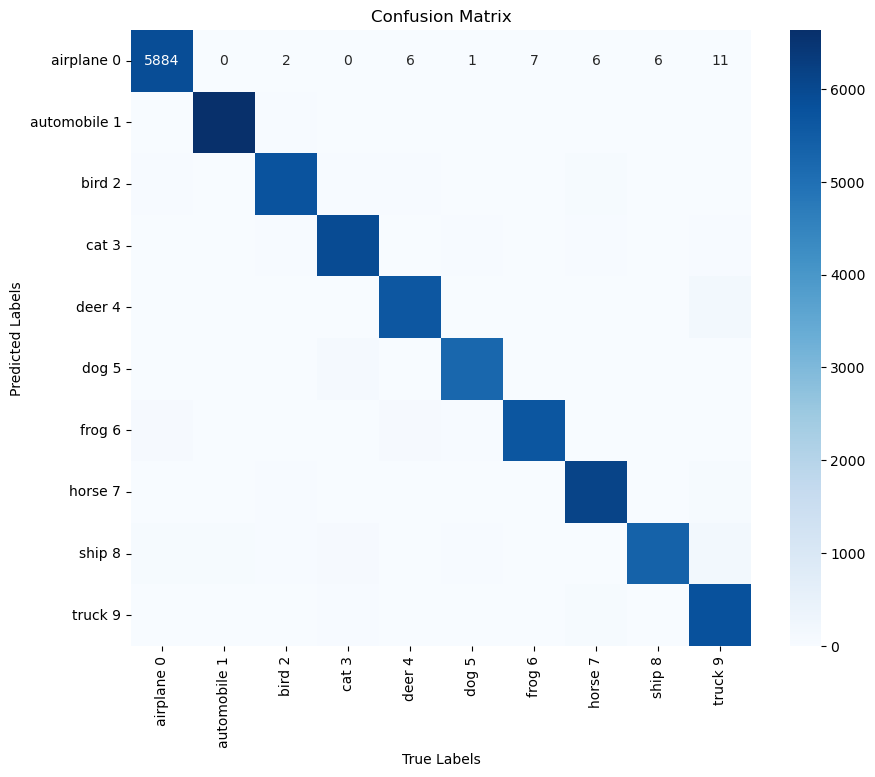

In [9]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, testloader, classes):
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to hold true labels and predicted labels
    all_labels = []
    all_preds = []

    # Iterate over the test dataset
    with torch.no_grad():  # Don't compute gradients during evaluation
        for data in testloader:
            images, labels = data  # Get images and corresponding labels
            outputs = model(images)  # Get model outputs
            _, predicted = torch.max(outputs, 1)  # Get predicted labels

            all_labels.extend(labels.cpu().numpy())  # Convert to CPU and extend
            all_preds.extend(predicted.cpu().numpy())  # Convert to CPU and extend

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix using Seaborn's heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.show()

# Example usage: Assuming testloader and class names are defined
# The 'classes' should be a list of class names for your dataset (e.g., CIFAR-10 classes)

# Call the function to calculate and plot the confusion matrix
plot_confusion_matrix(net, combined_loader, cifar_mnist_classes)

In [48]:
torch.save(net, 'model_cifar_mnist_1_full.pth')

In [6]:
net1 = torch.load('model_cifar_mnist_1_full.pth')

/var/folders/w5/cr9dv6h106v9sddn3p0_pt200000gn/T/ipykernel_14317/2558970798.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net1 = torch.load('model_cifar_mnist_1_full.p

In [7]:
net = net1
model = net